In [171]:
import matplotlib.pyplot as plt
import json
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling, Resizing, RandomFlip, RandomRotation

# Loading the dataset
We load the dataset and split it in train and validation(dev) set

In [172]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "dataset_plantvillage/train"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 8751 files belonging to 38 classes.
Using 7001 files for training.
Found 8751 files belonging to 38 classes.
Using 1750 files for validation.


# We try to inspect dataset

In [173]:
class_names = train_dataset.class_names
print(class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '4', '5', '6', '7', '8', '9']


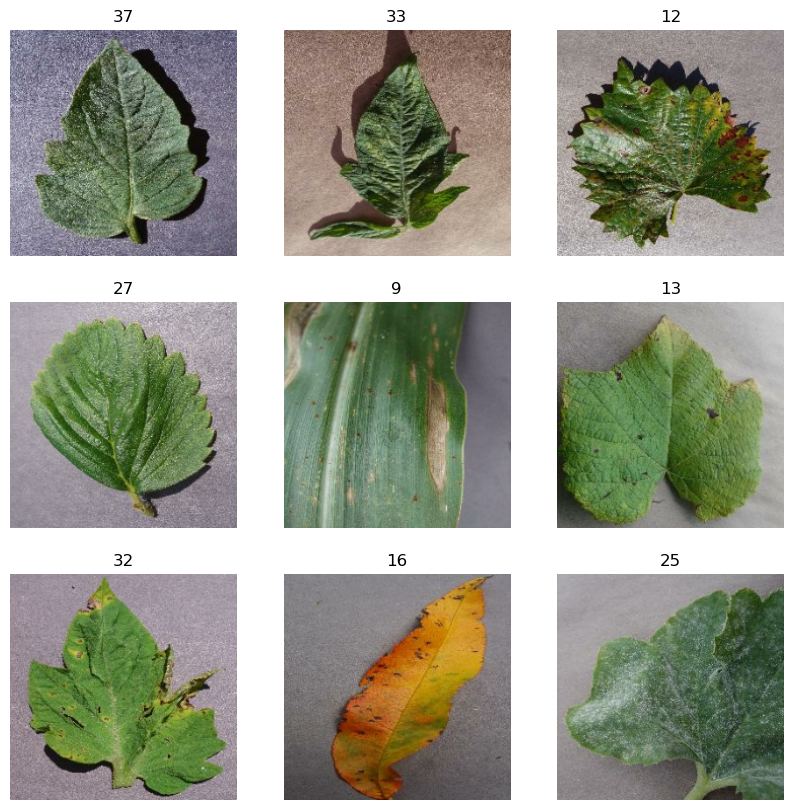

In [174]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# AUTOTUNE
For avoiding bottleneck,we use autotune. 

In [177]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

## Increase data
We add some data by flipping and rotate

In [178]:
def data_augmenter():

    data_augmentation = tf.keras.Sequential([
        RandomFlip('horizontal'),
        RandomRotation(0.2)
    ])
    
    return data_augmentation

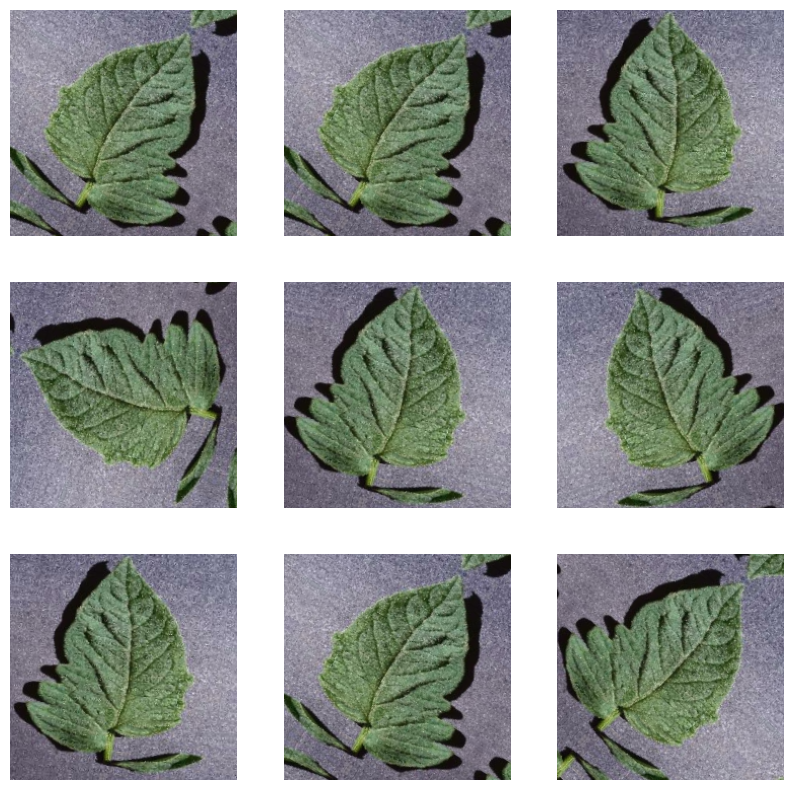

In [179]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [156]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [157]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model_path="imagenet_base_model/with_top_mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160.h5"

base_model = tf.keras.applications.EfficientNetV2B0(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [158]:
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)   │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_7 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ input_layer_28[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_7               │ (None, 224, 224, 3)       │               0 │ rescaling_7[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ normalization_7[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 112, 112, 16)      │           4,608 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 112, 112, 16)      │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 112, 112, 16)      │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_conv (Conv2D)  │ (None, 56, 56, 64)        │           9,216 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_bn             │ (None, 56, 56, 64)        │             256 │ block2a_expand_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_activation     │ (None, 56, 56, 64)        │               0 │ block2a_expand_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_project_conv (Conv2D) │ (None, 56, 56, 32)        │           2,048 │ block2a_expand_activation… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_project_bn            │ (None, 56, 56, 32)        │             128 │ block2a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 7,200,312 (27.47 MB)

 Trainable params: 7,139,704 (27.24 MB)

 Non-trainable params: 60,608 (236.75 KB)

### Inspect the number of layer

In [180]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

top_dropout
predictions


In [181]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [182]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([ 9, 17, 24,  8, 19,  7, 36, 27, 36,  4,  4, 21, 20, 23, 26,  7,  7,
        7,  7, 31,  1, 37, 32,  2,  2,  7, 19,  2, 26,  3,  0, 28],
      dtype=int32)>

In [183]:
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions

base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

# Function to decode predictions
#def decode_predictions(preds, top=2):
 #   results = []
  #  for pred in preds:
   #     top_indices = pred.argsort()[-top:][::-1]
    #    result = [tuple(class_index[str(i)]) + (pred[i],) for i in top_indices]
     #   results.append(result)
    #return results

#with open("imagenet_base_model/imagenet_class_index.json", 'r') as f:
#    class_index = json.load(f)
#################We can simply load it
#decoded_predictions = decode_predictions(pred.numpy(), top=2)
    
decoded_predictions = decode_predictions(pred.numpy(), top=2)
print(decoded_predictions)

[[('n03729826', 'matchstick', np.float32(0.018374579)), ('n01930112', 'nematode', np.float32(0.012721095))], [('n03729826', 'matchstick', np.float32(0.017141378)), ('n01930112', 'nematode', np.float32(0.011907635))], [('n03729826', 'matchstick', np.float32(0.014052407)), ('n01930112', 'nematode', np.float32(0.010169909))], [('n03729826', 'matchstick', np.float32(0.014209896)), ('n01930112', 'nematode', np.float32(0.010385897))], [('n03729826', 'matchstick', np.float32(0.017375661)), ('n01930112', 'nematode', np.float32(0.012135003))], [('n03729826', 'matchstick', np.float32(0.014059871)), ('n01930112', 'nematode', np.float32(0.010280308))], [('n03729826', 'matchstick', np.float32(0.018000303)), ('n01930112', 'nematode', np.float32(0.0127952555))], [('n03729826', 'matchstick', np.float32(0.01714621)), ('n01930112', 'nematode', np.float32(0.012039266))], [('n03729826', 'matchstick', np.float32(0.017499965)), ('n01930112', 'nematode', np.float32(0.0122014955))], [('n03729826', 'matchstick

# Disease model

In [189]:
def disease_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,)

    base_model_path = "imagenet_base_model/without_top_mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160_no_top.h5"

    base_model = tf.keras.applications.EfficientNetV2B0(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(38,activation='linear')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [190]:
model2 = disease_model(IMG_SIZE, data_augmentation)

In [191]:
model2.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_19 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_8 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_8 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,967,990 (22.77 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [192]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [193]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.1114 - loss: 3.3898 - val_accuracy: 0.0966 - val_loss: 3.4006
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.1128 - loss: 3.3558 - val_accuracy: 0.0966 - val_loss: 3.3246
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.1216 - loss: 3.3336 - val_accuracy: 0.0966 - val_loss: 3.3036
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - accuracy: 0.1246 - loss: 3.3136 - val_accuracy: 0.1497 - val_loss: 3.2928
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.1274 - loss: 3.3084 - val_accuracy: 0.1337 - val_loss: 3.2990


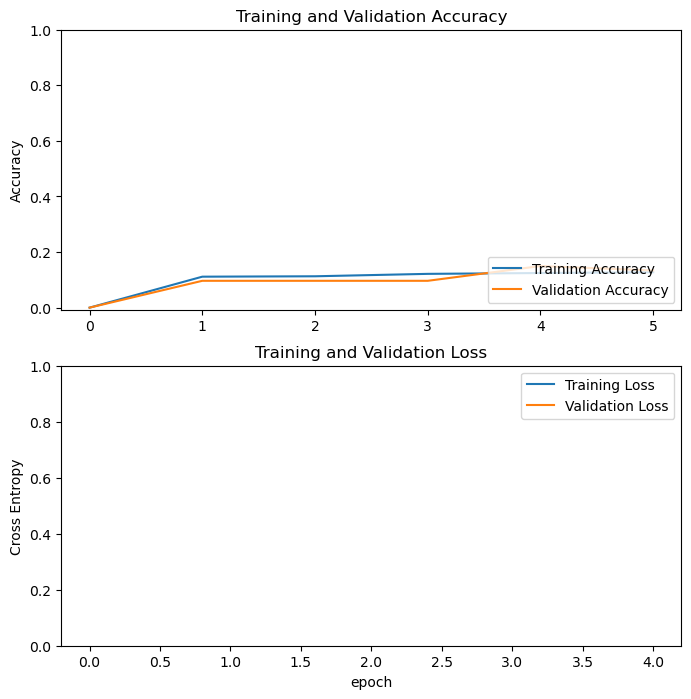

In [196]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [197]:
model2.layers

[<InputLayer name=input_layer_35, built=True>,
 <Sequential name=sequential_19, built=True>,
 <Functional name=efficientnetv2-b0, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling2d_11, built=True>,
 <Dropout name=dropout_8, built=True>,
 <Dense name=dense_8, built=True>]

In [200]:
base_model = model2
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

### START CODE HERE

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(0.1 * base_learning_rate)
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  6


In [201]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1304s 6s/step - accuracy: 0.1286 - loss: 3.3168 - val_accuracy: 0.1337 - val_loss: 3.2990
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.1276 - loss: 3.3200 - val_accuracy: 0.1337 - val_loss: 3.2990
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.1251 - loss: 3.3155 - val_accuracy: 0.1337 - val_loss: 3.2990
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.1297 - loss: 3.3157 - val_accuracy: 0.1337 - val_loss: 3.2990
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.1281 - loss: 3.3188 - val_accuracy: 0.1337 - val_loss: 3.2990
Epoch 10/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.1266 - loss: 3.3174 - val_accuracy: 0.1337 - val_loss: 3.2990


In [202]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

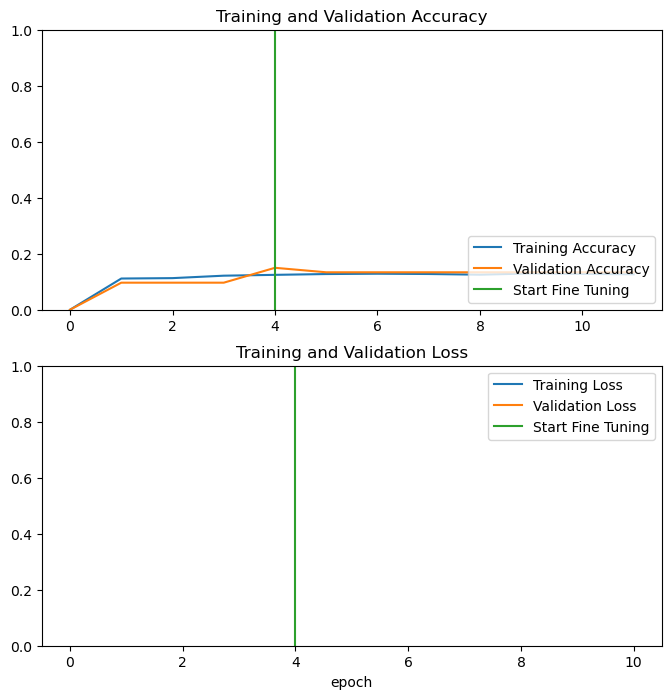

In [203]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [205]:
from joblib import dump
dump(model2,'agrimodel.h5')

['agrimodel.h5']